## Predicting Street Level Air Pollution in French cities

### Problem Statement
Air pollution is nowadays a major issue not only in countries such as China or India but also in developed countries. The World Health Organization estimate on the number of death due to poor air quality is close to 8 million (both indoor and outdoor) worldwide whereas the European Environmental Agency counted almost 450 000 premature deaths in Europe with the same cause. 

To monitor air quality, institutions and agencies are focusing on four main pollutants : 
- ozone (O3), 
- nitrogen dioxide (NO2),
- particulate matter with diameter below 2.5 μm (PM2.5),
- particulate matter with diameter below 10 μm (PM10).

Although regulated by national and European standards, evaluation of one's real exposure to air pollution at the street level is still a challenge today. Air quality monitoring is performed with expensive reference instruments (ideally) disseminated at strategic locations within the cities. However, because of pollutants' heterogeneity in terms of sources, volatility and chemical reactivity, pollutant concentrations can vary widely between very close areas and thus, one's exposure can vary accordingly.


### Introduction to Plume Labs
Plume Labs (http://www.plumelabs.com) is a French start-up which aims, through the use of open data, to provide to citizens information on their exposure to air pollution. This information is already available today for an increasing number of megalopolis through mobile applications, but the final goal of Plume Labs is to provide pollution levels at any point on the globe. To achieve this, physical models as well as artificial intelligence tools are used concurrently. 

We propose to predict the air quality level at the street level in several French cities. To reach this goal, we rely on an increasingly popular model in the atmospheric science community called **land use regression model (LURM)**. By using relevant parameters based on the land-use (e.g., the surface occupied by residential buildings within a given perimeter), as well as meteorological ones, matched with the monitoring station readings, it's possible to build a statistical model to predict air quality levels. Such models can then be used at other locations within the cities to construct a street-level air pollution map. Examples can be seen in the scientific literature :

http://www.sciencedirect.com/science/article/pii/S1877705815016331

http://www.sciencedirect.com/science/article/pii/S001393511530178X

### Objectives
The goal of the challenge is to predict three pollutants' (NO2, PM2_5, PM10) concentrations at the location of monitoring stations in several cities and at given time periods by focusing the training algorithms on :
- the regular structure of the time series (strong daily and seasonal cycles)
- the correlation between pollution and meteorology (temperature, precipitations,...)
- the correlation with static factors (e.g., length of roads within a buffer of x meters, density of residential/industrial/... buildings, see below for a complete description of the dataset)

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0  
* pandas>=0.17.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)  

In [64]:
from __future__ import division, print_function
import os
import sys
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_columns', None)

### Feature Description
Data sets are provided in CSV files, which we will import with pandas.

In [3]:
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')

### X_train dataset

In [55]:
X_train.head()

,ID,hlres_50,green_5000,hldres_50,daytime,route_100,precipintensity,precipprobability,hlres_1000,temperature,is_calmday,route_1000,roadinvdist,port_5000,windbearingsin,cloudcover,hldres_100,natural_5000,hlres_300,hldres_300,route_300,station_id,pressure,route_500,hlres_500,hlres_100,pollutant,industry_1000,zone_id,windbearingcos,windspeed,hldres_500,hldres_1000
0,0,NaN,5172542.5,3755.19043,72.0,NaN,0.6096,0.61,NaN,9.49,False,8027.166504,0.04678,NaN,-0.587785,1.00,13612.243164,5172542.5,NaN,114993.5625,NaN,16.0,1029.349976,NaN,NaN,NaN,NO2,NaN,0.0,0.809017,6.55,357436.1875,1542650.0
1,1,NaN,5172542.5,3755.19043,72.0,NaN,0.6096,0.61,NaN,9.49,False,8027.166504,0.04678,NaN,-0.587785,1.00,13612.243164,5172542.5,NaN,114993.5625,NaN,16.0,1029.349976,NaN,NaN,NaN,PM10,NaN,0.0,0.809017,6.55,357436.1875,1542650.0
2,2,NaN,5172542.5,3755.19043,73.0,NaN,0.0965,0.14,NaN,8.22,False,8027.166504,0.04678,NaN,-0.069756,1.00,13612.243164,5172542.5,NaN,114993.5625,NaN,16.0,1029.560059,NaN,NaN,NaN,NO2,NaN,0.0,0.997564,4.47,357436.1875,1542650.0
3,3,NaN,5172542.5,3755.19043,73.0,NaN,0.0965,0.14,NaN,8.22,False,8027.166504,0.04678,NaN,-0.069756,1.00,13612.243164,5172542.5,NaN,114993.5625,NaN,16.0,1029.560059,NaN,NaN,NaN,PM10,NaN,0.0,0.997564,4.47,357436.1875,1542650.0
4,4,NaN,5172542.5,3755.19043,74.0,NaN,0.0000,0.00,NaN,7.58,False,8027.166504,0.04678,NaN,-0.104528,0.97,13612.243164,5172542.5,NaN,114993.5625,NaN,16.0,1029.660034,NaN,NaN,NaN,NO2,NaN,0.0,0.994522,4.11,357436.1875,1542650.0


#### X_train dataset features
- ID: row ID of the dataset (from 0 to 448168)
- daytime: arbitrary value which describe the order in time, on an hourly basis, of the data
- zone_id: values range from 0 to 5 and describe a given city
- station_id: values are included in [ 16., 17., 20., 1., 18., 22., 26., 28., 6., 9., 25., 4., 10., 23., 5., 8., 11.]. A station is related to a given zone_id, several stations can be related to one city.
- pollutant name
- is_calmday (boolean): information on the type of day - basically discriminate week/week-end days and public holidays
- meteorological parameters:
    - temperature (double)
    - windspeed (double)
    - windbearing_cos (double)
    - windbearing_sin (double)
    - cloudcover (double)
    - precipitations_intensity (double)
    - precipitations_probability (double)
    - pressure (double)
- static variables: A buffer is a circle with a given diameter drawn around a position. As an example, HLRES_50 is the cumulated surface of High density residential land within a 50 m diameter circle.
    - HLRES: High density residential land (m2) - buffer of 50,100,300,500,1000 m
    - HLDRES: HLRES +Low density residential land (m2) - buffer of 50,100,300,500,1000 m
    - INDUSTRY: Industry land (m2) - buffer of 1000 m
    - PORT: Port land (m2) - buffer of 5000 m
    - NATURAL: Semi-natural and forested land (m2) - buffer of 5000 m
    - GREEN: urban parks and green areas + NATURAL (m2) - buffer of 5000 m
    - ROUTE: cumulated road distances within the buffer (m) - buffer of 100, 300, 500, 1000m
    - ROADINVDIST: inverse of distance between the station and the nearest road (1/m)
    
    
Important: when no data is provided, it means that:
- No land use is encompassed within the buffer for land use data
- No data is available for meteorological parameters

### Y_train dataset

In [5]:
Y_train.head()

,ID,TARGET
0,0,43.0
1,1,21.0
2,2,9.0
3,3,22.0
4,4,6.0


#### Y_train dataset columns
- ID: row ID to match the Xtrain dataset
- TARGET: pollutant concentration in μg/m3

In [12]:
Y_train.describe()['TARGET']

count    448169.000000
mean         20.286938
std          16.520396
min           1.487314
25%           9.000000
50%          16.000000
75%          27.000000
max         985.000000
Name: TARGET, dtype: float64

### Visualizing data for first week

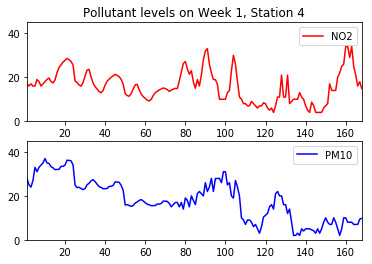

In [61]:
# Look at TARGET on first 7*24 hours, Station 4, Pollutant = NO2 and PM10
n = 24*7
y_NO2 = Y_train[Y_train['ID'].isin(list(X_train[(X_train['daytime']<n) & (X_train['station_id']==4.0) & (X_train['pollutant'] == 'NO2')]['ID']))]['TARGET']
y_PM10 = Y_train[Y_train['ID'].isin(list(X_train[(X_train['daytime']<n) & (X_train['station_id']==4.0) & (X_train['pollutant'] == 'PM10')]['ID']))]['TARGET']
hour = np.arange(1,n+1,1)


plt.subplot(211)
plt.title('Pollutant levels on Week 1, Station 4')
plt.plot(hour, y_NO2, 'red', label="NO2")
plt.axis([1, n, 0, 45])
plt.legend()
plt.subplot(212)
plt.plot(hour, y_PM10, 'blue', label="PM10")
plt.legend()
plt.axis([1, n, 0, 45])
plt.show()

### Test datasets
Note that in the test dataset, there may be data from stations that do not appear in the train dataset.

Our goal is to provide a Ytest dataset with 2 columns:
- ID: row ID which match the Xtest row IDs
- TARGET: results of the model for the given rows

In [62]:
X_test = pd.read_csv('X_test.csv')

## Prediction model 
We are going to follow the scikit-learn API specs in order to define a `FeatureExtractor` and a `Regressor`.

## The feature extractor

In <code>feature_extractor.py</code> you will define a class called <code>FeatureExtractor</code>. Its main <code>transform</code> method takes a pandas <b>DataFrame</b> and outputs a <b>numpy array</b>.

- The `FeatureExtractor` inherits from `TransformerMixin`.
- It implements a `fit` (optional) and a `transform` method. 

In [70]:
# insert Frapy's feat extractor
import pandas as pd
from sklearn.base import TransformerMixin


class FeatureExtractor(TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        X_df_ = pd.get_dummies(X_df, drop_first=False, columns=['pollutant'])
        return X_df_.values

## The regressor

- The `Regressor` inherits from `BaseEstimator`,
- The `__init__()` function initiates all of the arguments and configurations. 
- The regressor must implement a `fit()` and  a `predict()` function.

In [71]:
# insert frapy's regressor

from sklearn.base import BaseEstimator
from sklearn.ensemble import ExtraTreesRegressor


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = ExtraTreesRegressor(n_estimators=10)

    def fit(self, X, y):
        return self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)


    def predict(self, X):
        return self.reg.predict(X)

## Unit testing

Place the python file <code>regressor.py</code>, the data, and the <code>user_test_submission.py</code></a> in a directory and run 

<code>python user_test_submission.py</code>

In [ ]:
!python user_test_submission.py